In [1]:
import pandas as pd
import ast

In [3]:
path = 'Environmental Discourse'

In [32]:
env = pd.read_pickle('../Data/'+path+'/env_0.pkl')
env = env.sample(10)

In [10]:
env.head()

source                                                url  \
20339  Resilience  https://www.resilience.org/stories/2008-07-08/...   
87817       Grist  https://grist.org/article/the-blame-the-enviro...   
63974       Grist  https://grist.org/climate/heres-how-coronaviru...   
94514       Grist  https://grist.org/article/2011-01-21-meet-the-...   
57887       Grist  https://grist.org/living/3-disturbing-facts-pr...   

                                                   title       date  \
20339                                      Asia – July 8 2008-07-08   
87817        A possible smear campaign fingers greens... 2005-09-17   
63974        Here’s how coronavirus affected carbon e... 2020-05-19   
94514                       Meet the Climate Fockers     2011-01-22   
57887        3 disturbing facts prove sexual harassme... 2015-04-16   

                 author                                               text  \
20339             Staff  .     Japan sees a chance to promote its energ...   
87817      Emily Gertz   The Gonzales Justice Department may be seeking...   
63974   Zoya Teirstein   The pandemic is far from over, but some states...   
94514  Auden Schendler   Here’a repost from my Climateprogress.org blog...   
57887      Eve Andrews   Hello! On this spring-shiny day, are you think...   

       year  
20339  2008  
87817  2005  
63974  2020  
94514  2011  
57887  2015

# Sentence tokenize

In [21]:
import dask.dataframe as dd
from gensim.utils import effective_n_jobs
import spacy
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")

In [28]:
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner", "lemmatizer"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [29]:
def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.lemma_))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.text.strip()))

    return normalized

In [30]:
def sent_tokenize(word_list, model=nlp):
    doc = model(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [38]:
def ngram_tagger(tokens):
    n = len(tokens)
    i = 0
    tokens_q = []
    tokens_qt = []
    tokens_qtb = []
    
    # quadgrams
    while i < n:
        words = '_'.join(tokens[i:i+4])
        if words in quadgrams:
            tokens_q.append(words)
            i += 4
        else:
            tokens_q.append(tokens[i])
            i += 1
    
    # trigrams
    n = len(tokens_q)
    i = 0
    while i < n:
        words = '_'.join(tokens_q[i:i+3])
        if words in trigrams:
            tokens_qt.append(words)
            i += 3
        else:
            tokens_qt.append(tokens_q[i])
            i += 1
    
    # bigrams
    n = len(tokens_qt)
    i = 0
    while i < n:
        words = '_'.join(tokens_qt[i:i+2])
        if words in bigrams:
            tokens_qtb.append(words)
            i += 2
        else:
            tokens_qtb.append(tokens_qt[i])
            i += 1
    
    return tokens_qtb

In [37]:
quadgrams = [('intergovernmental', 'panel', 'climate', 'change'),
             ('natural', 'resources', 'defense', 'council'),
             ('coal', 'fired', 'power', 'plants'),
             ('national', 'oceanic', 'atmospheric', 'administration')]

tr = pd.read_csv('../Data/' + path + '/trigrams.csv', converters={'Unnamed: 0': ast.literal_eval})
tr.columns = ['trigram', 'freq', 'tag']
trigrams = [t for t in tr[tr.tag == 1].trigram]

b = pd.read_csv('../Data/' + path + '/bigrams.csv', converters={'Unnamed: 0': ast.literal_eval})
b.columns = ['bigram', 'freq', 'tag']
bigrams = [t for t in b[b.tag == 1].bigram]

quadgrams = ['_'.join(t) for t in quadgrams]
trigrams = ['_'.join(t) for t in trigrams]
bigrams = ['_'.join(t) for t in bigrams]

In [33]:
%%time
d_env = dd.from_pandas(env, npartitions=effective_n_jobs(-1))
d_env['tokenized_sents'] = d_env.text.map(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
d_env['normalized_sents'] = d_env.tokenized_sents.map(lambda x: [normalizeTokens(s, lemma=False) for s in x])
env = d_env.compute()

CPU times: user 1min 29s, sys: 1min 32s, total: 3min 2s
Wall time: 1min 8s


In [34]:
%%time
d_env = dd.from_pandas(env, npartitions=effective_n_jobs(-1))
d_env['tokenized_sents'] = d_env.text.map(lambda x: [normalizeTokens(word_tokenize(s), lemma=False) for s in sent_tokenize(x)])
env = d_env.compute()

CPU times: user 45.6 s, sys: 47.4 s, total: 1min 33s
Wall time: 35.2 s


In [66]:
env = pd.read_pickle('../Data/'+path+'/env_0.pkl')
env = env.sample(100, random_state=1)

In [67]:
%%time
d_env = dd.from_pandas(env, npartitions=1)
d_env['sents'] = d_env.text.map(lambda x: [ngram_tagger(
                                           normalizeTokens(
                                           word_tokenize(s), lemma=False)) for s in sent_tokenize(x)])
d_env['sents'] = d_env.sents.map(lambda x: [s for s in x if len(s)>0])
env = d_env.compute()

CPU times: user 58.9 s, sys: 0 ns, total: 58.9 s
Wall time: 58.9 s


In [68]:
env = pd.read_pickle('../Data/'+path+'/env_0.pkl')
env = env.sample(100, random_state=1)

In [69]:
%%time
d_env = dd.from_pandas(env, npartitions=effective_n_jobs(-1))
d_env['sents'] = d_env.text.map(lambda x: [ngram_tagger(
                                           normalizeTokens(
                                           word_tokenize(s), lemma=False)) for s in sent_tokenize(x)])
d_env['sents'] = d_env.sents.map(lambda x: [s for s in x if len(s)>0])
env = d_env.compute()

CPU times: user 2min 39s, sys: 1min 59s, total: 4min 39s
Wall time: 2min 1s


In [68]:
env = pd.read_pickle('../Data/'+path+'/env_0.pkl')
env = env.sample(100, random_state=1)

In [71]:
%%time
env['sents'] = env.text.apply(lambda x: [ngram_tagger(
                                           normalizeTokens(
                                           word_tokenize(s), lemma=False)) for s in sent_tokenize(x)])
env['sents'] = env.sents.apply(lambda x: [s for s in x if len(s)>0])

CPU times: user 45 s, sys: 0 ns, total: 45 s
Wall time: 45 s


In [46]:
len(env.sents.sum())

474

In [47]:
env.sents.apply(len)

13914      9
17262    140
20294     58
21056     19
42392     79
43608     36
49334     17
49402     75
59600     30
78212     11
Name: sents, dtype: int64

In [19]:
env.shape

(1000, 7)

In [ ]:
d_env = dd.from_pandas(env_tok, npartitions=effective_n_jobs(-1))

# Start here 3/16

In [32]:
! pip install gensim==4

     |████████████████████████████████| 23.1 MB 12 kB/s s eta 0:00:01
  Created wheel for gensim: filename=gensim-4.0.0-cp39-cp39-linux_x86_64.whl size=23921427 sha256=8373e6b0be40cc9600a331a0272958235f264f5d782d266fd3bcd4301204b6fc
  Stored in directory: /home/mcpackard/.cache/pip/wheels/58/8b/5f/53deafbdad45cf0d3d3c0189d1f29b309bfd6950abe2f58a70
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.3
    Uninstalling gensim-3.8.3:
      Successfully uninstalled gensim-3.8.3


In [30]:
import pandas as pd
import gensim
import numpy as np
import sklearn.metrics.pairwise #For cosine similarity
import plotly.express as px
from gensim import corpora, models

In [2]:
gensim.__version__

'4.0.0'

In [3]:
dfs = []
for i in range(5,22):
    j = str(i)
    k = (2 - len(j)) * '0' + j
    dfs.append(pd.read_pickle('../Data/Environmental Discourse/sent_processing/env_processed_sent_{}.pkl'.format(k)))

In [4]:
we = []
for df in dfs:
    we.append(gensim.models.word2vec.Word2Vec(df.sents.sum(), sg=1))

In [7]:
we_aligned = we[0:1]
for emb in we[1:]:
    aligned = smart_procrustes_align_gensim(we_aligned[-1], emb)
    we_aligned.append(aligned)

starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting
starting


In [8]:
# Save 'em
for i, w in enumerate(we):
    w.save("../Data/Environmental Discourse/Word-Embeddings/w2v_raw_{}".format(i+2005))

for i, w in enumerate(we_aligned):
    w.save("../Data/Environmental Discourse/Word-Embeddings/w2v_aligned_{}".format(i+2005))

**Let's look specifically at food and agriculture**

In [9]:
tm_09 = pd.read_pickle('../Data/Environmental Discourse/env_tm09_loadings.pkl')

In [11]:
labels_09 = ['renewables',
             'knowledge',
             'community',
             'food',
             'politics',
             'fossil fuels',
             'economy',
             'urbanism',
             'climate change']

tm_09['topic'] = tm_09[labels_09].idxmax(axis=1)

In [12]:
avg_food_loading = tm_09.groupby('year').food.mean()
n_food_articles = tm_09[tm_09.topic == 'food'].groupby('year').food.count()

In [15]:
px.line(avg_food_loading)

In [20]:
ntr = pd.read_pickle('../Data/Environmental Discourse/Full-TMs/ntr365.pkl')

In [22]:
df = pd.merge(tm_09, ntr, on=['url', 'title', 'date', 'year'], how='inner')

In [63]:
food_resonance = df[df.topic=='food'].groupby('year').resonance.mean()
food_novelty = df[df.topic=='food'].groupby('year').novelty.mean()
food_transience = df[df.topic=='food'].groupby('year').transience.mean()

In [26]:
px.line(food_resonance)

In [62]:
px.line(food_novelty)

In [64]:
px.line(food_transience)

In [65]:
food_novelty

year
2005    12.918096
2006    13.024264
2007    12.977138
2008    13.008876
2009    12.928695
2010    13.027521
2011    12.880465
2012    13.161572
2013    12.966614
2014    12.832292
2015    13.024969
2016    13.096203
2017    12.783953
2018    12.809432
2019    12.554040
2020    13.018705
2021    13.201209
Name: novelty, dtype: float64

In [66]:
food_transience

year
2005    12.964499
2006    13.019983
2007    12.955465
2008    12.969981
2009    12.945028
2010    13.031554
2011    12.870135
2012    13.149822
2013    12.938970
2014    12.811330
2015    13.005811
2016    13.103778
2017    12.876308
2018    12.851685
2019    12.496510
2020    13.008265
2021    13.335726
Name: transience, dtype: float64

In [67]:
px.scatter(df, x='novelty', y='transience', opacity=0.5)

In [31]:
lda = models.ldamodel.LdaModel.load('../Data/Environmental Discourse/Full-TMs/Models/tm_09')

In [44]:
top200_food_words = [w for w, p in lda.show_topic(labels_09.index('food'), 200)]

In [52]:
avg_food_div = []

for y in range(16):

    we_dict = {2005 + y: we_aligned[y],
               2005 + y + 1: we_aligned[y+1]}

    divs = []
    n_not_found = 0
    for word in top200_food_words:
        try:
            divs.append(findDivergence(word, we_dict))
        except KeyError:
            n_not_found += 1
    
    avg_food_div.append(sum(divs)/len(divs))

avg_food_div = pd.Series(avg_food_div, index=range(2006, 2022))

In [53]:
px.line(avg_food_div)

In [70]:
# Zooming in on 2017 in food
food17 = df[(df.topic == 'food') & (df.year == 2017)]

In [73]:
px.scatter(x=food17.date, y=food17.resonance)

In [74]:
px.scatter(x=food17.date, y=food17.novelty)

Idea for analysis:
 - Get resonance score for each article (done)
 - Find the words that have shifted the most since the previous year (doable)
 - Is there a positive association between resonance (or novelty) and using the shifted words?

I have these different metrics: resonance, topic loadings, and semantic changes
They seem to be correlated.
What does them being correlated or not correlated say about the corpus? What RQ could this answer?

The next thing I do has to be my last analysis.

Was just thinking about taking the top 20 words in the food topic and measuring the average distance to the top 20 words in each other topic. See which topics are closest and how that changes. That's just dynamic topic modeling dawg.

I just need a good punchline. I have a lot of interesting stuff to show. I just need a good punchline.

In [104]:
not_food = [l for l in labels_09 if l != 'food']
px.line(df[df.topic=='food'].groupby('year')[labels_09].mean())

In [87]:
import statsmodels.api as sm

In [99]:
df['community_x_year'] = df.community * df.year

In [105]:
mod = sm.OLS(df.food, sm.add_constant(df[['community', 'community_x_year']], prepend=False))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   food   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     157.0
Date:                Wed, 16 Mar 2022   Prob (F-statistic):           1.06e-68
Time:                        22:13:55   Log-Likelihood:                 17868.
No. Observations:               46825   AIC:                        -3.573e+04
Df Residuals:                   46822   BIC:                        -3.570e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
community            4.4721      1.965  

/home/mcpackard/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [86]:
reg = LinearRegression().fit(df[['community']], df.food)
reg

LinearRegression()

In [125]:
loadings_pairwise = pd.DataFrame(index=labels_09)
for t in labels_09:
    #print(df[df.topic==t][labels_09].mean())
    loadings_pairwise[t] = list(df[df.topic==t][labels_09].mean())
    loadings_pairwise.loc[t, t] = np.nan

In [118]:
import seaborn as sns

<AxesSubplot:>

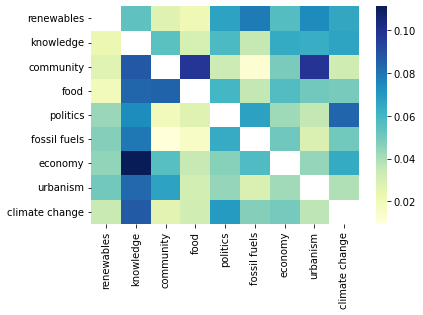

In [126]:
sns.heatmap(loadings_pairwise.transpose(), cmap="YlGnBu")

In [132]:
df[df.food > 0.8].resonance.mean()

0.013545240846745361

In [133]:
df[df.community > 0.8].resonance.mean()

-0.009080959133647684

In [134]:
df[(df.community > 0.35) & (df.food > 0.35)].resonance.mean()

-0.01905584291767237

In [123]:
df[df.topic=='knowledge'][labels_09].mean()

renewables        0.022647
knowledge         0.597228
community         0.055014
food              0.030155
politics          0.058366
fossil fuels      0.035013
economy           0.064628
urbanism          0.063221
climate change    0.067073
dtype: float64

In [42]:
def findDivergence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    div = 1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]].wv[word], axis = 0), np.expand_dims(embeddingsDict[cats[1]].wv[word], axis = 0))[0,0]
    return div

def findMostDivergent(embeddingsDict):
    words = []
    for embed in embeddingsDict.values():
        words += list(embed.wv.index_to_key)
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [6]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)
    

    # get the (normalized) embedding matrices
    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)  
     
    
    return other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        print("starting")
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        #print(indices)
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        #print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)